In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../data_in/CE_Crateus.csv'
data_output_path = '../data_out/weather.csv'
data_output_path_npsave = '../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

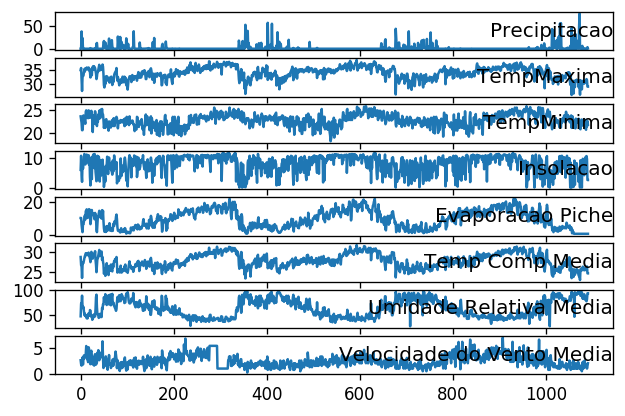

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return (x_train, y_train, x_test, y_test)

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return model

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# calculate metrics
def metrics(model, x_test, y_test, scaler):
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    rmse = sqrt(mean_squared_error(y_test, inv_y_hat))
    variance = explained_variance_score(y_test, inv_y_hat)
    maxError = np.max(np.abs(y_test - inv_y_hat))
    meanAbsolutError = mean_absolute_error(y_test, inv_y_hat)
    medianAbsoluteError = np.median(np.abs(y_test - inv_y_hat))
    
    return [rmse, variance, maxError, meanAbsolutError, medianAbsoluteError]

In [11]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler=None):
    metrics_list = []
    rmse = []
    variance = []
    maxError = []
    meanAbsolutError = []
    medianAbsoluteError = []
    i = len(days_to_predict) - 1
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        model = myLSTM(x_train, y_train, x_test, y_test, scaler)    
        metrics_list += metrics(model, x_test, y_test, scaler)
        
        rmse += [metrics_list[0]]
        variance += [metrics_list[1]]
        maxError += [metrics_list[2]]
        meanAbsolutError += [metrics_list[3]]
        medianAbsoluteError += [metrics_list[4]]
        
        i -= 1
        dataset = dataset[:-1]
        
    print('Test RMSE -------------------------- {:.4}'.format(np.mean(rmse)))
    print('Test VARIANCE ---------------------- {:.4}'.format(np.mean(variance)))
    print('Test MAX-ERROR --------------------- {:.4}'.format(np.mean(maxError)))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(np.mean(meanAbsolutError)))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(np.mean(medianAbsoluteError)))

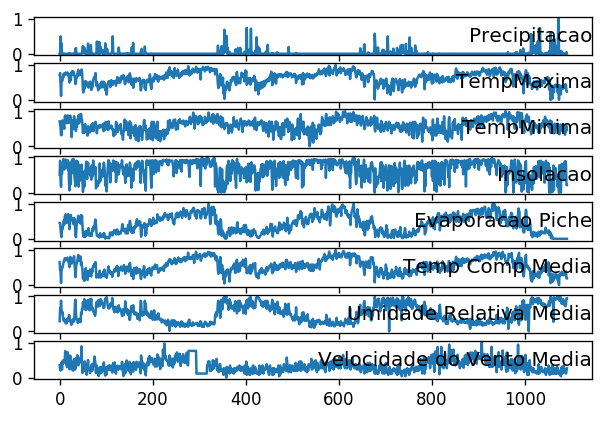

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3233 - mean_squared_error: 0.1538 - val_loss: 0.2324 - val_mean_squared_error: 0.0622
Epoch 2/1000
 - 0s - loss: 0.1524 - mean_squared_error: 0.0369 - val_loss: 0.1958 - val_mean_squared_error: 0.0529
Epoch 3/1000
 - 0s - loss: 0.1404 - mean_squared_error: 0.0317 - val_loss: 0.1626 - val_mean_squared_error: 0.0354
Epoch 4/1000
 - 0s - loss: 0.1330 - mean_squared_error: 0.0287 - val_loss: 0.1615 - val_mean_squared_error: 0.0450
Epoch 5/1000
 - 0s - loss: 0.1255 - mean_squared_error: 0.0255 - val_loss: 0.1574 - val_mean_squared_error: 0.0453
Epoch 6/1000
 - 0s - loss: 0.1168 - mean_squared_error: 0.0226 - val_loss: 0.1647 - val_mean_squared_error: 0.0452
Epoch 7/1000
 - 0s - loss: 0.1130 - mean_squared_error: 0.0211 - val_loss: 0.1585 - val_mean_squared_error: 0.0493
Epoch 8/1000
 - 0s - loss: 0.1103 - mean_squared_error: 0.0202 - val_loss: 0.1774 - val_mean_squared_error: 0.0427
Epoch 9/1000
 - 0s - loss: 0.1078 -

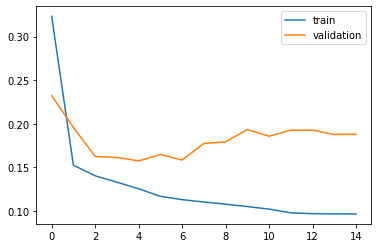


predict: [[39.71651051 33.4725226 ]]
real:      [[18.09923077 31.95789474]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3573 - mean_squared_error: 0.1832 - val_loss: 0.1823 - val_mean_squared_error: 0.0333
Epoch 2/1000
 - 0s - loss: 0.1608 - mean_squared_error: 0.0394 - val_loss: 0.1502 - val_mean_squared_error: 0.0227
Epoch 3/1000
 - 0s - loss: 0.1363 - mean_squared_error: 0.0293 - val_loss: 0.1160 - val_mean_squared_error: 0.0135
Epoch 4/1000
 - 0s - loss: 0.1308 - mean_squared_error: 0.0269 - val_loss: 0.1050 - val_mean_squared_error: 0.0111
Epoch 5/1000
 - 0s - loss: 0.1247 - mean_squared_error: 0.0247 - val_loss: 0.1319 - val_mean_squared_error: 0.0175
Epoch 6/1000
 - 0s - loss: 0.1179 - mean_squared_error: 0.0224 - val_loss: 0.1873 - val_mean_squared_error: 0.0355
Epoch 7/1000
 - 0s - loss: 0.1184 - mean_squared_error: 0.0228 - val_loss: 0.1574 - val_mean_squared_error: 0.0248
Epoch 8/1000
 - 0s - loss: 0.1133 - mean_squared_error: 0.0212 - val_los

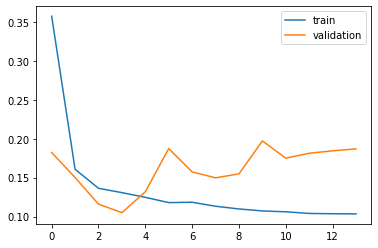


predict: [[36.6113212  32.50778114]]
real:      [[18.09923077 33.32631579]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3759 - mean_squared_error: 0.1956 - val_loss: 0.1233 - val_mean_squared_error: 0.0230
Epoch 2/1000
 - 0s - loss: 0.1578 - mean_squared_error: 0.0404 - val_loss: 0.1032 - val_mean_squared_error: 0.0109
Epoch 3/1000
 - 0s - loss: 0.1380 - mean_squared_error: 0.0304 - val_loss: 0.0403 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 0s - loss: 0.1322 - mean_squared_error: 0.0280 - val_loss: 0.0484 - val_mean_squared_error: 0.0028
Epoch 5/1000
 - 0s - loss: 0.1244 - mean_squared_error: 0.0250 - val_loss: 0.0501 - val_mean_squared_error: 0.0031
Epoch 6/1000
 - 0s - loss: 0.1129 - mean_squared_error: 0.0210 - val_loss: 0.0381 - val_mean_squared_error: 0.0026
Epoch 7/1000
 - 0s - loss: 0.1131 - mean_squared_error: 0.0207 - val_loss: 0.0386 - val_mean_squared_error: 0.0018
Epoch 8/1000
 - 0s - loss: 0.1086 - mean_squared_error: 0.0197 - val_los

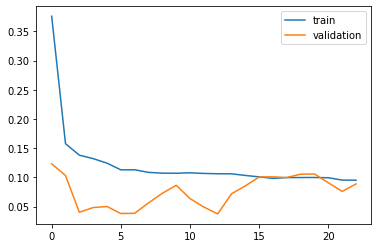


predict: [[31.48812585 33.22013741]]
real:      [[32.11153846 31.27368421]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2539 - mean_squared_error: 0.0987 - val_loss: 0.2109 - val_mean_squared_error: 0.0496
Epoch 2/1000
 - 0s - loss: 0.1495 - mean_squared_error: 0.0344 - val_loss: 0.1812 - val_mean_squared_error: 0.0366
Epoch 3/1000
 - 0s - loss: 0.1399 - mean_squared_error: 0.0309 - val_loss: 0.1559 - val_mean_squared_error: 0.0292
Epoch 4/1000
 - 0s - loss: 0.1346 - mean_squared_error: 0.0280 - val_loss: 0.2114 - val_mean_squared_error: 0.0488
Epoch 5/1000
 - 0s - loss: 0.1283 - mean_squared_error: 0.0260 - val_loss: 0.1796 - val_mean_squared_error: 0.0378
Epoch 6/1000
 - 0s - loss: 0.1208 - mean_squared_error: 0.0233 - val_loss: 0.1940 - val_mean_squared_error: 0.0418
Epoch 7/1000
 - 0s - loss: 0.1131 - mean_squared_error: 0.0208 - val_loss: 0.2067 - val_mean_squared_error: 0.0462
Epoch 8/1000
 - 0s - loss: 0.1109 - mean_squared_error: 0.0201 - val_los

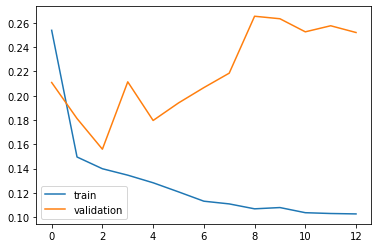


predict: [[36.89605451 33.32577955]]
real:      [[34.44692308 33.66842105]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3854 - mean_squared_error: 0.2114 - val_loss: 0.2646 - val_mean_squared_error: 0.0708
Epoch 2/1000
 - 0s - loss: 0.1680 - mean_squared_error: 0.0455 - val_loss: 0.0833 - val_mean_squared_error: 0.0093
Epoch 3/1000
 - 0s - loss: 0.1391 - mean_squared_error: 0.0311 - val_loss: 0.1825 - val_mean_squared_error: 0.0341
Epoch 4/1000
 - 0s - loss: 0.1319 - mean_squared_error: 0.0274 - val_loss: 0.1899 - val_mean_squared_error: 0.0383
Epoch 5/1000
 - 0s - loss: 0.1259 - mean_squared_error: 0.0255 - val_loss: 0.1601 - val_mean_squared_error: 0.0278
Epoch 6/1000
 - 0s - loss: 0.1209 - mean_squared_error: 0.0238 - val_loss: 0.1799 - val_mean_squared_error: 0.0345
Epoch 7/1000
 - 0s - loss: 0.1154 - mean_squared_error: 0.0215 - val_loss: 0.2204 - val_mean_squared_error: 0.0510
Epoch 8/1000
 - 0s - loss: 0.1109 - mean_squared_error: 0.0204 - val_los

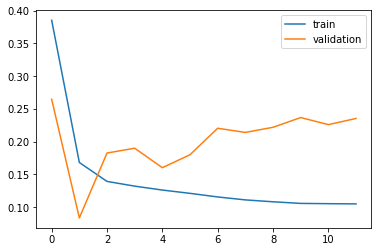


predict: [[32.91699497 31.76821254]]
real:      [[30.36       30.07631579]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3210 - mean_squared_error: 0.1425 - val_loss: 0.2064 - val_mean_squared_error: 0.0669
Epoch 2/1000
 - 0s - loss: 0.1776 - mean_squared_error: 0.0473 - val_loss: 0.1539 - val_mean_squared_error: 0.0271
Epoch 3/1000
 - 0s - loss: 0.1440 - mean_squared_error: 0.0332 - val_loss: 0.1744 - val_mean_squared_error: 0.0314
Epoch 4/1000
 - 0s - loss: 0.1360 - mean_squared_error: 0.0297 - val_loss: 0.1586 - val_mean_squared_error: 0.0256
Epoch 5/1000
 - 0s - loss: 0.1283 - mean_squared_error: 0.0273 - val_loss: 0.1539 - val_mean_squared_error: 0.0244
Epoch 6/1000
 - 0s - loss: 0.1205 - mean_squared_error: 0.0242 - val_loss: 0.1939 - val_mean_squared_error: 0.0385
Epoch 7/1000
 - 0s - loss: 0.1126 - mean_squared_error: 0.0212 - val_loss: 0.1816 - val_mean_squared_error: 0.0341
Epoch 8/1000
 - 0s - loss: 0.1111 - mean_squared_error: 0.0203 - val_los

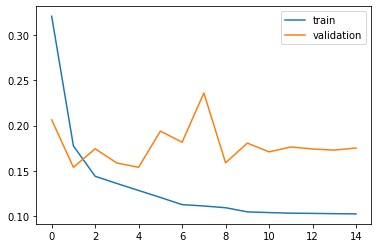


predict: [[34.42729594 32.9213063 ]]
real:      [[28.60846154 30.41842105]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5172 - mean_squared_error: 0.3290 - val_loss: 0.0480 - val_mean_squared_error: 0.0034
Epoch 2/1000
 - 0s - loss: 0.1763 - mean_squared_error: 0.0489 - val_loss: 0.1580 - val_mean_squared_error: 0.0443
Epoch 3/1000
 - 0s - loss: 0.1459 - mean_squared_error: 0.0337 - val_loss: 0.1684 - val_mean_squared_error: 0.0374
Epoch 4/1000
 - 0s - loss: 0.1377 - mean_squared_error: 0.0302 - val_loss: 0.1786 - val_mean_squared_error: 0.0392
Epoch 5/1000
 - 0s - loss: 0.1338 - mean_squared_error: 0.0293 - val_loss: 0.1331 - val_mean_squared_error: 0.0238
Epoch 6/1000
 - 0s - loss: 0.1268 - mean_squared_error: 0.0260 - val_loss: 0.1405 - val_mean_squared_error: 0.0274
Epoch 7/1000
 - 0s - loss: 0.1225 - mean_squared_error: 0.0240 - val_loss: 0.1497 - val_mean_squared_error: 0.0264
Epoch 8/1000
 - 0s - loss: 0.1161 - mean_squared_error: 0.0222 - val_los

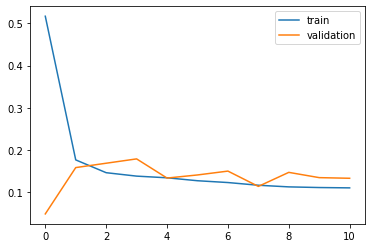


predict: [[23.96411326 33.42336236]]
real:      [[28.02461538 31.61578947]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3921 - mean_squared_error: 0.2093 - val_loss: 0.2285 - val_mean_squared_error: 0.0772
Epoch 2/1000
 - 0s - loss: 0.1526 - mean_squared_error: 0.0383 - val_loss: 0.1567 - val_mean_squared_error: 0.0326
Epoch 3/1000
 - 0s - loss: 0.1387 - mean_squared_error: 0.0302 - val_loss: 0.1474 - val_mean_squared_error: 0.0270
Epoch 4/1000
 - 0s - loss: 0.1332 - mean_squared_error: 0.0276 - val_loss: 0.1129 - val_mean_squared_error: 0.0203
Epoch 5/1000
 - 0s - loss: 0.1195 - mean_squared_error: 0.0231 - val_loss: 0.1661 - val_mean_squared_error: 0.0322
Epoch 6/1000
 - 0s - loss: 0.1104 - mean_squared_error: 0.0200 - val_loss: 0.1818 - val_mean_squared_error: 0.0459
Epoch 7/1000
 - 0s - loss: 0.1075 - mean_squared_error: 0.0192 - val_loss: 0.1826 - val_mean_squared_error: 0.0600
Epoch 8/1000
 - 0s - loss: 0.1056 - mean_squared_error: 0.0188 - val_los

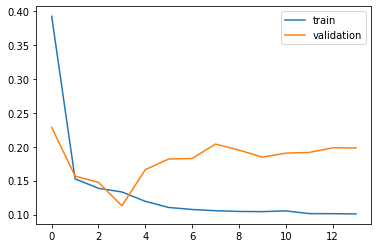


predict: [[33.2128867  33.64485698]]
real:      [[26.27307692 32.64210526]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4796 - mean_squared_error: 0.2988 - val_loss: 0.0553 - val_mean_squared_error: 0.0033
Epoch 2/1000
 - 0s - loss: 0.1710 - mean_squared_error: 0.0452 - val_loss: 0.0605 - val_mean_squared_error: 0.0049
Epoch 3/1000
 - 0s - loss: 0.1488 - mean_squared_error: 0.0340 - val_loss: 0.0918 - val_mean_squared_error: 0.0167
Epoch 4/1000
 - 0s - loss: 0.1395 - mean_squared_error: 0.0306 - val_loss: 0.0565 - val_mean_squared_error: 0.0052
Epoch 5/1000
 - 0s - loss: 0.1343 - mean_squared_error: 0.0284 - val_loss: 0.0912 - val_mean_squared_error: 0.0127
Epoch 6/1000
 - 0s - loss: 0.1301 - mean_squared_error: 0.0266 - val_loss: 0.0928 - val_mean_squared_error: 0.0104
Epoch 7/1000
 - 0s - loss: 0.1257 - mean_squared_error: 0.0251 - val_loss: 0.0958 - val_mean_squared_error: 0.0138
Epoch 8/1000
 - 0s - loss: 0.1186 - mean_squared_error: 0.0226 - val_los

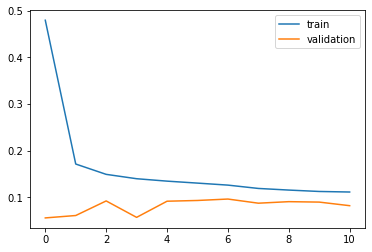


predict: [[20.26597782 33.2863655 ]]
real:      [[24.52153846 34.01052632]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3249 - mean_squared_error: 0.1810 - val_loss: 0.1536 - val_mean_squared_error: 0.0238
Epoch 2/1000
 - 0s - loss: 0.1524 - mean_squared_error: 0.0374 - val_loss: 0.0844 - val_mean_squared_error: 0.0123
Epoch 3/1000
 - 0s - loss: 0.1432 - mean_squared_error: 0.0328 - val_loss: 0.0859 - val_mean_squared_error: 0.0123
Epoch 4/1000
 - 0s - loss: 0.1354 - mean_squared_error: 0.0303 - val_loss: 0.0887 - val_mean_squared_error: 0.0116
Epoch 5/1000
 - 0s - loss: 0.1274 - mean_squared_error: 0.0270 - val_loss: 0.0989 - val_mean_squared_error: 0.0141
Epoch 6/1000
 - 0s - loss: 0.1204 - mean_squared_error: 0.0241 - val_loss: 0.1022 - val_mean_squared_error: 0.0148
Epoch 7/1000
 - 0s - loss: 0.1164 - mean_squared_error: 0.0229 - val_loss: 0.1076 - val_mean_squared_error: 0.0153
Epoch 8/1000
 - 0s - loss: 0.1131 - mean_squared_error: 0.0216 - val_los

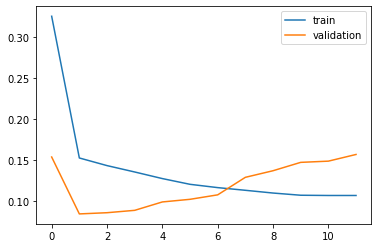


predict: [[40.57955257 32.26520528]]
real:      [[30.94384615 33.49736842]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3204 - mean_squared_error: 0.1475 - val_loss: 0.1595 - val_mean_squared_error: 0.0302
Epoch 2/1000
 - 0s - loss: 0.1553 - mean_squared_error: 0.0384 - val_loss: 0.0788 - val_mean_squared_error: 0.0063
Epoch 3/1000
 - 0s - loss: 0.1408 - mean_squared_error: 0.0307 - val_loss: 0.0643 - val_mean_squared_error: 0.0066
Epoch 4/1000
 - 0s - loss: 0.1370 - mean_squared_error: 0.0295 - val_loss: 0.0909 - val_mean_squared_error: 0.0108
Epoch 5/1000
 - 0s - loss: 0.1339 - mean_squared_error: 0.0280 - val_loss: 0.0771 - val_mean_squared_error: 0.0077
Epoch 6/1000
 - 0s - loss: 0.1329 - mean_squared_error: 0.0276 - val_loss: 0.0819 - val_mean_squared_error: 0.0113
Epoch 7/1000
 - 0s - loss: 0.1260 - mean_squared_error: 0.0252 - val_loss: 0.0672 - val_mean_squared_error: 0.0086
Epoch 8/1000
 - 0s - loss: 0.1183 - mean_squared_error: 0.0228 - val_los

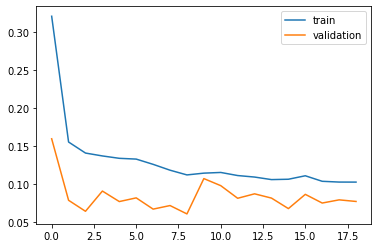


predict: [[30.97553488 32.51437597]]
real:      [[30.94384615 32.64210526]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5273 - mean_squared_error: 0.3335 - val_loss: 0.1738 - val_mean_squared_error: 0.0326
Epoch 2/1000
 - 0s - loss: 0.2211 - mean_squared_error: 0.0761 - val_loss: 0.2696 - val_mean_squared_error: 0.0776
Epoch 3/1000
 - 0s - loss: 0.1469 - mean_squared_error: 0.0333 - val_loss: 0.1276 - val_mean_squared_error: 0.0181
Epoch 4/1000
 - 0s - loss: 0.1368 - mean_squared_error: 0.0292 - val_loss: 0.1792 - val_mean_squared_error: 0.0335
Epoch 5/1000
 - 0s - loss: 0.1329 - mean_squared_error: 0.0274 - val_loss: 0.1708 - val_mean_squared_error: 0.0296
Epoch 6/1000
 - 0s - loss: 0.1284 - mean_squared_error: 0.0259 - val_loss: 0.1662 - val_mean_squared_error: 0.0281
Epoch 7/1000
 - 0s - loss: 0.1244 - mean_squared_error: 0.0244 - val_loss: 0.1640 - val_mean_squared_error: 0.0294
Epoch 8/1000
 - 0s - loss: 0.1194 - mean_squared_error: 0.0226 - val_los

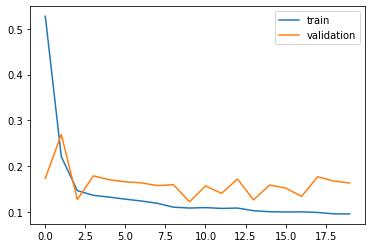


predict: [[37.16815909 31.677507  ]]
real:      [[30.36       33.49736842]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3230 - mean_squared_error: 0.1520 - val_loss: 0.3312 - val_mean_squared_error: 0.1568
Epoch 2/1000
 - 0s - loss: 0.1581 - mean_squared_error: 0.0402 - val_loss: 0.2165 - val_mean_squared_error: 0.0594
Epoch 3/1000
 - 0s - loss: 0.1424 - mean_squared_error: 0.0318 - val_loss: 0.1979 - val_mean_squared_error: 0.0775
Epoch 4/1000
 - 0s - loss: 0.1356 - mean_squared_error: 0.0289 - val_loss: 0.1953 - val_mean_squared_error: 0.0698
Epoch 5/1000
 - 0s - loss: 0.1287 - mean_squared_error: 0.0263 - val_loss: 0.1892 - val_mean_squared_error: 0.0716
Epoch 6/1000
 - 0s - loss: 0.1168 - mean_squared_error: 0.0222 - val_loss: 0.2028 - val_mean_squared_error: 0.0758
Epoch 7/1000
 - 0s - loss: 0.1097 - mean_squared_error: 0.0199 - val_loss: 0.2339 - val_mean_squared_error: 0.0798
Epoch 8/1000
 - 0s - loss: 0.1087 - mean_squared_error: 0.0200 - val_los

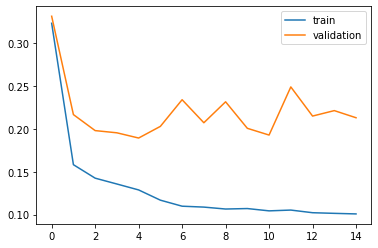


predict: [[31.43493049 32.74016951]]
real:      [[28.60846154 31.61578947]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6126 - mean_squared_error: 0.4070 - val_loss: 0.3800 - val_mean_squared_error: 0.2037
Epoch 2/1000
 - 0s - loss: 0.3382 - mean_squared_error: 0.1618 - val_loss: 0.2158 - val_mean_squared_error: 0.0517
Epoch 3/1000
 - 0s - loss: 0.1616 - mean_squared_error: 0.0453 - val_loss: 0.2118 - val_mean_squared_error: 0.0511
Epoch 4/1000
 - 0s - loss: 0.1445 - mean_squared_error: 0.0329 - val_loss: 0.1912 - val_mean_squared_error: 0.0549
Epoch 5/1000
 - 0s - loss: 0.1357 - mean_squared_error: 0.0304 - val_loss: 0.1642 - val_mean_squared_error: 0.0411
Epoch 6/1000
 - 0s - loss: 0.1308 - mean_squared_error: 0.0277 - val_loss: 0.1451 - val_mean_squared_error: 0.0385
Epoch 7/1000
 - 0s - loss: 0.1274 - mean_squared_error: 0.0266 - val_loss: 0.1750 - val_mean_squared_error: 0.0487
Epoch 8/1000
 - 0s - loss: 0.1220 - mean_squared_error: 0.0246 - val_los

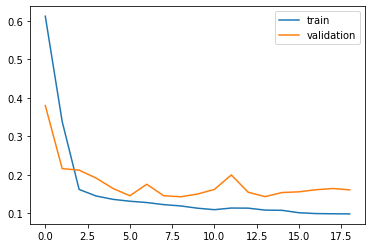


predict: [[32.29272697 33.12399428]]
real:      [[12.26076923 33.83947368]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2379 - mean_squared_error: 0.0881 - val_loss: 0.1846 - val_mean_squared_error: 0.0363
Epoch 2/1000
 - 0s - loss: 0.1444 - mean_squared_error: 0.0324 - val_loss: 0.1303 - val_mean_squared_error: 0.0178
Epoch 3/1000
 - 0s - loss: 0.1360 - mean_squared_error: 0.0292 - val_loss: 0.1507 - val_mean_squared_error: 0.0227
Epoch 4/1000
 - 0s - loss: 0.1297 - mean_squared_error: 0.0267 - val_loss: 0.1383 - val_mean_squared_error: 0.0192
Epoch 5/1000
 - 0s - loss: 0.1214 - mean_squared_error: 0.0242 - val_loss: 0.1538 - val_mean_squared_error: 0.0236
Epoch 6/1000
 - 0s - loss: 0.1168 - mean_squared_error: 0.0223 - val_loss: 0.1484 - val_mean_squared_error: 0.0220
Epoch 7/1000
 - 0s - loss: 0.1123 - mean_squared_error: 0.0208 - val_loss: 0.1502 - val_mean_squared_error: 0.0226
Epoch 8/1000
 - 0s - loss: 0.1070 - mean_squared_error: 0.0195 - val_los

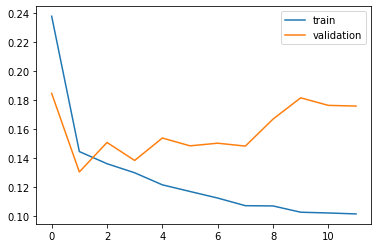


predict: [[34.34496833 33.0203722 ]]
real:      [[21.60230769 33.83947368]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2553 - mean_squared_error: 0.1024 - val_loss: 0.1646 - val_mean_squared_error: 0.0283
Epoch 2/1000
 - 0s - loss: 0.1545 - mean_squared_error: 0.0384 - val_loss: 0.2051 - val_mean_squared_error: 0.0440
Epoch 3/1000
 - 0s - loss: 0.1376 - mean_squared_error: 0.0300 - val_loss: 0.2032 - val_mean_squared_error: 0.0428
Epoch 4/1000
 - 0s - loss: 0.1265 - mean_squared_error: 0.0258 - val_loss: 0.1917 - val_mean_squared_error: 0.0399
Epoch 5/1000
 - 0s - loss: 0.1160 - mean_squared_error: 0.0219 - val_loss: 0.1959 - val_mean_squared_error: 0.0423
Epoch 6/1000
 - 0s - loss: 0.1113 - mean_squared_error: 0.0203 - val_loss: 0.2005 - val_mean_squared_error: 0.0420
Epoch 7/1000
 - 0s - loss: 0.1082 - mean_squared_error: 0.0195 - val_loss: 0.2195 - val_mean_squared_error: 0.0501
Epoch 8/1000
 - 0s - loss: 0.1067 - mean_squared_error: 0.0192 - val_los

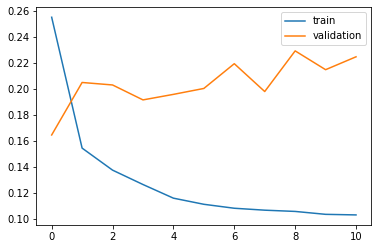


predict: [[37.84353688 31.69409831]]
real:      [[28.60846154 31.78684211]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2649 - mean_squared_error: 0.1062 - val_loss: 0.4619 - val_mean_squared_error: 0.2721
Epoch 2/1000
 - 0s - loss: 0.1485 - mean_squared_error: 0.0346 - val_loss: 0.3643 - val_mean_squared_error: 0.1571
Epoch 3/1000
 - 0s - loss: 0.1392 - mean_squared_error: 0.0301 - val_loss: 0.3906 - val_mean_squared_error: 0.1772
Epoch 4/1000
 - 0s - loss: 0.1351 - mean_squared_error: 0.0282 - val_loss: 0.3794 - val_mean_squared_error: 0.1789
Epoch 5/1000
 - 0s - loss: 0.1277 - mean_squared_error: 0.0259 - val_loss: 0.3739 - val_mean_squared_error: 0.1680
Epoch 6/1000
 - 0s - loss: 0.1181 - mean_squared_error: 0.0225 - val_loss: 0.4424 - val_mean_squared_error: 0.2271
Epoch 7/1000
 - 0s - loss: 0.1128 - mean_squared_error: 0.0208 - val_loss: 0.3869 - val_mean_squared_error: 0.1945
Epoch 8/1000
 - 0s - loss: 0.1088 - mean_squared_error: 0.0197 - val_los

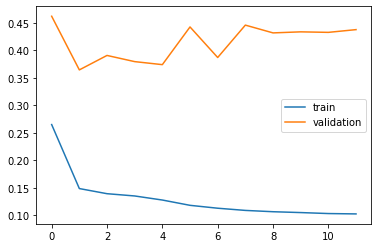


predict: [[35.46675109 33.30751531]]
real:      [[32.11153846 30.24736842]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3840 - mean_squared_error: 0.1942 - val_loss: 0.3653 - val_mean_squared_error: 0.1340
Epoch 2/1000
 - 0s - loss: 0.1707 - mean_squared_error: 0.0472 - val_loss: 0.1783 - val_mean_squared_error: 0.0361
Epoch 3/1000
 - 0s - loss: 0.1481 - mean_squared_error: 0.0342 - val_loss: 0.2899 - val_mean_squared_error: 0.0853
Epoch 4/1000
 - 0s - loss: 0.1387 - mean_squared_error: 0.0302 - val_loss: 0.2821 - val_mean_squared_error: 0.0804
Epoch 5/1000
 - 0s - loss: 0.1334 - mean_squared_error: 0.0285 - val_loss: 0.2700 - val_mean_squared_error: 0.0733
Epoch 6/1000
 - 0s - loss: 0.1286 - mean_squared_error: 0.0261 - val_loss: 0.2809 - val_mean_squared_error: 0.0802
Epoch 7/1000
 - 0s - loss: 0.1196 - mean_squared_error: 0.0230 - val_loss: 0.2534 - val_mean_squared_error: 0.0651
Epoch 8/1000
 - 0s - loss: 0.1156 - mean_squared_error: 0.0217 - val_los

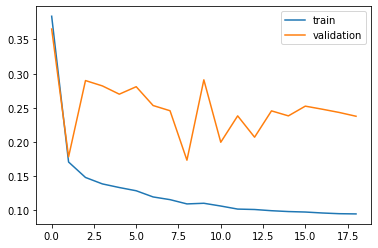


predict: [[28.7445076  31.60073074]]
real:      [[ 0.58384615 30.76052632]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4815 - mean_squared_error: 0.2816 - val_loss: 0.2472 - val_mean_squared_error: 0.0617
Epoch 2/1000
 - 0s - loss: 0.2133 - mean_squared_error: 0.0684 - val_loss: 0.1218 - val_mean_squared_error: 0.0174
Epoch 3/1000
 - 0s - loss: 0.1424 - mean_squared_error: 0.0329 - val_loss: 0.1504 - val_mean_squared_error: 0.0235
Epoch 4/1000
 - 0s - loss: 0.1359 - mean_squared_error: 0.0306 - val_loss: 0.1254 - val_mean_squared_error: 0.0157
Epoch 5/1000
 - 0s - loss: 0.1314 - mean_squared_error: 0.0281 - val_loss: 0.1459 - val_mean_squared_error: 0.0213
Epoch 6/1000
 - 0s - loss: 0.1256 - mean_squared_error: 0.0257 - val_loss: 0.1477 - val_mean_squared_error: 0.0218
Epoch 7/1000
 - 0s - loss: 0.1189 - mean_squared_error: 0.0234 - val_loss: 0.2206 - val_mean_squared_error: 0.0487
Epoch 8/1000
 - 0s - loss: 0.1136 - mean_squared_error: 0.0217 - val_los

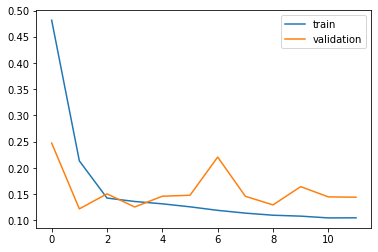


predict: [[40.58672762 31.90473326]]
real:      [[19.85076923 30.58947368]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3883 - mean_squared_error: 0.1955 - val_loss: 0.1951 - val_mean_squared_error: 0.0385
Epoch 2/1000
 - 0s - loss: 0.2300 - mean_squared_error: 0.0781 - val_loss: 0.0966 - val_mean_squared_error: 0.0106
Epoch 3/1000
 - 0s - loss: 0.1862 - mean_squared_error: 0.0531 - val_loss: 0.1692 - val_mean_squared_error: 0.0440
Epoch 4/1000
 - 0s - loss: 0.1522 - mean_squared_error: 0.0378 - val_loss: 0.1801 - val_mean_squared_error: 0.0535
Epoch 5/1000
 - 0s - loss: 0.1424 - mean_squared_error: 0.0322 - val_loss: 0.2047 - val_mean_squared_error: 0.0757
Epoch 6/1000
 - 0s - loss: 0.1380 - mean_squared_error: 0.0310 - val_loss: 0.2171 - val_mean_squared_error: 0.0695
Epoch 7/1000
 - 0s - loss: 0.1380 - mean_squared_error: 0.0311 - val_loss: 0.2235 - val_mean_squared_error: 0.0713
Epoch 8/1000
 - 0s - loss: 0.1363 - mean_squared_error: 0.0294 - val_los

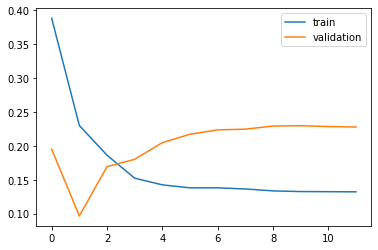


predict: [[24.83911675 32.85024773]]
real:      [[30.94384615 31.61578947]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6627 - mean_squared_error: 0.4762 - val_loss: 0.4438 - val_mean_squared_error: 0.1986
Epoch 2/1000
 - 0s - loss: 0.5473 - mean_squared_error: 0.3358 - val_loss: 0.2749 - val_mean_squared_error: 0.0787
Epoch 3/1000
 - 0s - loss: 0.2738 - mean_squared_error: 0.1146 - val_loss: 0.2501 - val_mean_squared_error: 0.0779
Epoch 4/1000
 - 0s - loss: 0.1529 - mean_squared_error: 0.0363 - val_loss: 0.1141 - val_mean_squared_error: 0.0141
Epoch 5/1000
 - 0s - loss: 0.1394 - mean_squared_error: 0.0308 - val_loss: 0.1146 - val_mean_squared_error: 0.0191
Epoch 6/1000
 - 0s - loss: 0.1376 - mean_squared_error: 0.0296 - val_loss: 0.1205 - val_mean_squared_error: 0.0160
Epoch 7/1000
 - 0s - loss: 0.1328 - mean_squared_error: 0.0281 - val_loss: 0.1065 - val_mean_squared_error: 0.0132
Epoch 8/1000
 - 0s - loss: 0.1306 - mean_squared_error: 0.0270 - val_los

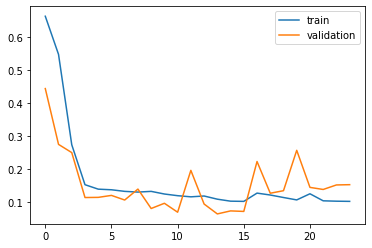


predict: [[32.0307109  32.75416969]]
real:      [[16.93153846 34.18157895]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3920 - mean_squared_error: 0.1986 - val_loss: 0.0582 - val_mean_squared_error: 0.0051
Epoch 2/1000
 - 0s - loss: 0.1603 - mean_squared_error: 0.0416 - val_loss: 0.0485 - val_mean_squared_error: 0.0030
Epoch 3/1000
 - 0s - loss: 0.1437 - mean_squared_error: 0.0321 - val_loss: 0.1449 - val_mean_squared_error: 0.0212
Epoch 4/1000
 - 0s - loss: 0.1350 - mean_squared_error: 0.0284 - val_loss: 0.0999 - val_mean_squared_error: 0.0102
Epoch 5/1000
 - 0s - loss: 0.1306 - mean_squared_error: 0.0267 - val_loss: 0.1392 - val_mean_squared_error: 0.0206
Epoch 6/1000
 - 0s - loss: 0.1243 - mean_squared_error: 0.0244 - val_loss: 0.1200 - val_mean_squared_error: 0.0158
Epoch 7/1000
 - 0s - loss: 0.1157 - mean_squared_error: 0.0222 - val_loss: 0.1058 - val_mean_squared_error: 0.0128
Epoch 8/1000
 - 0s - loss: 0.1117 - mean_squared_error: 0.0207 - val_los

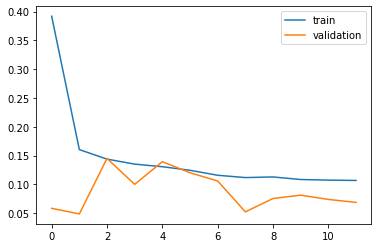


predict: [[32.86986175 32.24337049]]
real:      [[31.52769231 32.64210526]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4692 - mean_squared_error: 0.3211 - val_loss: 0.3370 - val_mean_squared_error: 0.1885
Epoch 2/1000
 - 0s - loss: 0.3412 - mean_squared_error: 0.1730 - val_loss: 0.3479 - val_mean_squared_error: 0.1249
Epoch 3/1000
 - 0s - loss: 0.2295 - mean_squared_error: 0.0826 - val_loss: 0.1338 - val_mean_squared_error: 0.0197
Epoch 4/1000
 - 0s - loss: 0.1445 - mean_squared_error: 0.0330 - val_loss: 0.0663 - val_mean_squared_error: 0.0053
Epoch 5/1000
 - 0s - loss: 0.1359 - mean_squared_error: 0.0293 - val_loss: 0.0967 - val_mean_squared_error: 0.0105
Epoch 6/1000
 - 0s - loss: 0.1297 - mean_squared_error: 0.0270 - val_loss: 0.0818 - val_mean_squared_error: 0.0113
Epoch 7/1000
 - 0s - loss: 0.1246 - mean_squared_error: 0.0252 - val_loss: 0.1254 - val_mean_squared_error: 0.0233
Epoch 8/1000
 - 0s - loss: 0.1198 - mean_squared_error: 0.0237 - val_los

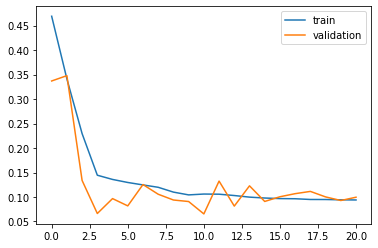


predict: [[22.67594484 31.96404611]]
real:      [[30.94384615 32.64210526]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6082 - mean_squared_error: 0.4178 - val_loss: 0.3955 - val_mean_squared_error: 0.1630
Epoch 2/1000
 - 0s - loss: 0.2579 - mean_squared_error: 0.0984 - val_loss: 0.1488 - val_mean_squared_error: 0.0323
Epoch 3/1000
 - 0s - loss: 0.1564 - mean_squared_error: 0.0407 - val_loss: 0.1054 - val_mean_squared_error: 0.0131
Epoch 4/1000
 - 0s - loss: 0.1406 - mean_squared_error: 0.0307 - val_loss: 0.0651 - val_mean_squared_error: 0.0076
Epoch 5/1000
 - 0s - loss: 0.1342 - mean_squared_error: 0.0286 - val_loss: 0.0683 - val_mean_squared_error: 0.0050
Epoch 6/1000
 - 0s - loss: 0.1251 - mean_squared_error: 0.0249 - val_loss: 0.0930 - val_mean_squared_error: 0.0091
Epoch 7/1000
 - 0s - loss: 0.1215 - mean_squared_error: 0.0239 - val_loss: 0.0599 - val_mean_squared_error: 0.0036
Epoch 8/1000
 - 0s - loss: 0.1161 - mean_squared_error: 0.0223 - val_los

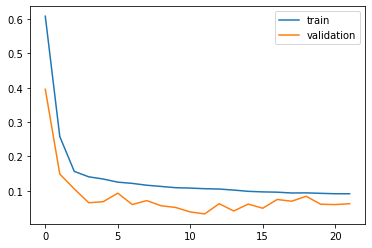


predict: [[35.83299317 32.64890413]]
real:      [[30.36       33.49736842]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.5035 - mean_squared_error: 0.3071 - val_loss: 0.2370 - val_mean_squared_error: 0.0578
Epoch 2/1000
 - 0s - loss: 0.2109 - mean_squared_error: 0.0702 - val_loss: 0.2384 - val_mean_squared_error: 0.0604
Epoch 3/1000
 - 0s - loss: 0.1496 - mean_squared_error: 0.0350 - val_loss: 0.0916 - val_mean_squared_error: 0.0164
Epoch 4/1000
 - 0s - loss: 0.1354 - mean_squared_error: 0.0281 - val_loss: 0.1223 - val_mean_squared_error: 0.0246
Epoch 5/1000
 - 0s - loss: 0.1323 - mean_squared_error: 0.0270 - val_loss: 0.1130 - val_mean_squared_error: 0.0230
Epoch 6/1000
 - 0s - loss: 0.1305 - mean_squared_error: 0.0264 - val_loss: 0.1097 - val_mean_squared_error: 0.0183
Epoch 7/1000
 - 0s - loss: 0.1286 - mean_squared_error: 0.0257 - val_loss: 0.1086 - val_mean_squared_error: 0.0176
Epoch 8/1000
 - 0s - loss: 0.1280 - mean_squared_error: 0.0257 - val_los

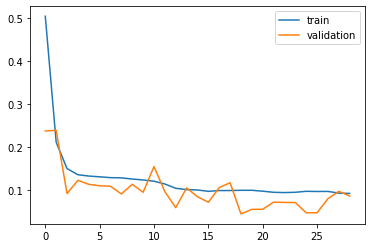


predict: [[33.24982962 33.05135654]]
real:      [[33.27923077 33.83947368]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3670 - mean_squared_error: 0.1885 - val_loss: 0.1071 - val_mean_squared_error: 0.0178
Epoch 2/1000
 - 0s - loss: 0.1554 - mean_squared_error: 0.0378 - val_loss: 0.1070 - val_mean_squared_error: 0.0124
Epoch 3/1000
 - 0s - loss: 0.1404 - mean_squared_error: 0.0306 - val_loss: 0.0965 - val_mean_squared_error: 0.0094
Epoch 4/1000
 - 0s - loss: 0.1329 - mean_squared_error: 0.0278 - val_loss: 0.0995 - val_mean_squared_error: 0.0119
Epoch 5/1000
 - 0s - loss: 0.1222 - mean_squared_error: 0.0237 - val_loss: 0.1023 - val_mean_squared_error: 0.0105
Epoch 6/1000
 - 0s - loss: 0.1148 - mean_squared_error: 0.0214 - val_loss: 0.1168 - val_mean_squared_error: 0.0143
Epoch 7/1000
 - 0s - loss: 0.1094 - mean_squared_error: 0.0194 - val_loss: 0.0968 - val_mean_squared_error: 0.0094
Epoch 8/1000
 - 0s - loss: 0.1042 - mean_squared_error: 0.0180 - val_los

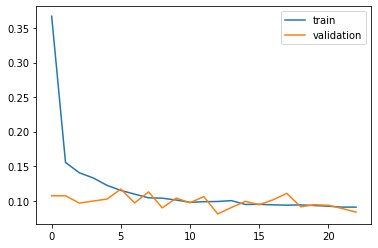


predict: [[27.9700996  32.28473758]]
real:      [[29.77615385 33.66842105]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4310 - mean_squared_error: 0.2626 - val_loss: 0.1257 - val_mean_squared_error: 0.0244
Epoch 2/1000
 - 0s - loss: 0.1699 - mean_squared_error: 0.0452 - val_loss: 0.1547 - val_mean_squared_error: 0.0344
Epoch 3/1000
 - 0s - loss: 0.1497 - mean_squared_error: 0.0359 - val_loss: 0.1705 - val_mean_squared_error: 0.0291
Epoch 4/1000
 - 0s - loss: 0.1399 - mean_squared_error: 0.0308 - val_loss: 0.1959 - val_mean_squared_error: 0.0392
Epoch 5/1000
 - 0s - loss: 0.1294 - mean_squared_error: 0.0270 - val_loss: 0.1736 - val_mean_squared_error: 0.0310
Epoch 6/1000
 - 0s - loss: 0.1195 - mean_squared_error: 0.0233 - val_loss: 0.1540 - val_mean_squared_error: 0.0249
Epoch 7/1000
 - 0s - loss: 0.1130 - mean_squared_error: 0.0207 - val_loss: 0.1125 - val_mean_squared_error: 0.0138
Epoch 8/1000
 - 0s - loss: 0.1106 - mean_squared_error: 0.0199 - val_los

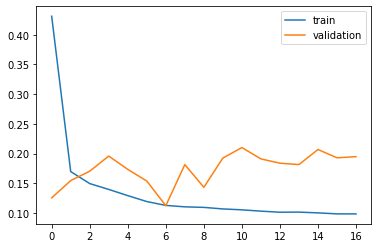


predict: [[26.53411651 32.34729283]]
real:      [[31.52769231 34.18157895]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3975 - mean_squared_error: 0.2089 - val_loss: 0.1689 - val_mean_squared_error: 0.0391
Epoch 2/1000
 - 0s - loss: 0.1551 - mean_squared_error: 0.0377 - val_loss: 0.1374 - val_mean_squared_error: 0.0375
Epoch 3/1000
 - 0s - loss: 0.1433 - mean_squared_error: 0.0318 - val_loss: 0.1791 - val_mean_squared_error: 0.0477
Epoch 4/1000
 - 0s - loss: 0.1384 - mean_squared_error: 0.0300 - val_loss: 0.1484 - val_mean_squared_error: 0.0421
Epoch 5/1000
 - 0s - loss: 0.1343 - mean_squared_error: 0.0282 - val_loss: 0.1767 - val_mean_squared_error: 0.0506
Epoch 6/1000
 - 0s - loss: 0.1279 - mean_squared_error: 0.0260 - val_loss: 0.1592 - val_mean_squared_error: 0.0459
Epoch 7/1000
 - 0s - loss: 0.1167 - mean_squared_error: 0.0223 - val_loss: 0.1617 - val_mean_squared_error: 0.0362
Epoch 8/1000
 - 0s - loss: 0.1060 - mean_squared_error: 0.0191 - val_los

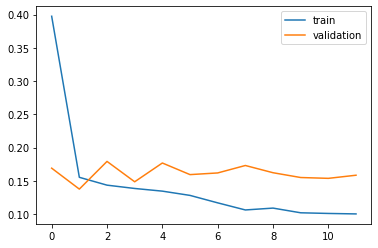


predict: [[33.1083033  32.85804592]]
real:      [[30.36       30.58947368]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4981 - mean_squared_error: 0.2858 - val_loss: 0.1994 - val_mean_squared_error: 0.0556
Epoch 2/1000
 - 0s - loss: 0.1880 - mean_squared_error: 0.0572 - val_loss: 0.1110 - val_mean_squared_error: 0.0135
Epoch 3/1000
 - 0s - loss: 0.1499 - mean_squared_error: 0.0346 - val_loss: 0.0975 - val_mean_squared_error: 0.0184
Epoch 4/1000
 - 0s - loss: 0.1399 - mean_squared_error: 0.0316 - val_loss: 0.1154 - val_mean_squared_error: 0.0188
Epoch 5/1000
 - 0s - loss: 0.1340 - mean_squared_error: 0.0282 - val_loss: 0.1130 - val_mean_squared_error: 0.0205
Epoch 6/1000
 - 0s - loss: 0.1294 - mean_squared_error: 0.0264 - val_loss: 0.1221 - val_mean_squared_error: 0.0258
Epoch 7/1000
 - 0s - loss: 0.1235 - mean_squared_error: 0.0244 - val_loss: 0.1322 - val_mean_squared_error: 0.0298
Epoch 8/1000
 - 0s - loss: 0.1169 - mean_squared_error: 0.0220 - val_los

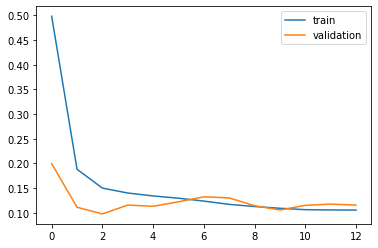


predict: [[34.61915847 33.1797974 ]]
real:      [[16.93153846 33.49736842]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4891 - mean_squared_error: 0.2826 - val_loss: 0.1189 - val_mean_squared_error: 0.0146
Epoch 2/1000
 - 0s - loss: 0.1735 - mean_squared_error: 0.0469 - val_loss: 0.1328 - val_mean_squared_error: 0.0178
Epoch 3/1000
 - 0s - loss: 0.1404 - mean_squared_error: 0.0308 - val_loss: 0.1918 - val_mean_squared_error: 0.0368
Epoch 4/1000
 - 0s - loss: 0.1335 - mean_squared_error: 0.0281 - val_loss: 0.1425 - val_mean_squared_error: 0.0207
Epoch 5/1000
 - 0s - loss: 0.1289 - mean_squared_error: 0.0263 - val_loss: 0.1464 - val_mean_squared_error: 0.0216
Epoch 6/1000
 - 0s - loss: 0.1248 - mean_squared_error: 0.0249 - val_loss: 0.1566 - val_mean_squared_error: 0.0251
Epoch 7/1000
 - 0s - loss: 0.1183 - mean_squared_error: 0.0223 - val_loss: 0.1838 - val_mean_squared_error: 0.0340
Epoch 8/1000
 - 0s - loss: 0.1133 - mean_squared_error: 0.0209 - val_los

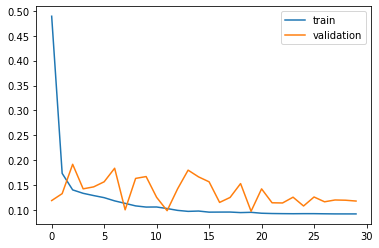


predict: [[32.09487016 32.48155676]]
real:      [[25.10538462 33.66842105]]

Test RMSE -------------------------- 36.38
Test VARIANCE ---------------------- 1.0
Test MAX-ERROR --------------------- 39.48
Test MEAN-ABSOLUTE-ERROR ----------- 36.24
Test MEDIAN-ABSOLUTE-ERROR --------- 36.24


In [12]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

min_max_scaler = preprocessing.MinMaxScaler()
values_scaled = min_max_scaler.fit_transform(values)
dataset_scaled = DataFrame(values_scaled)
dataset_scaled.index = dataset.index
dataset_scaled.columns = dataset.columns

plot_columns(values_scaled)

NCV(dataset_scaled, days_to_predict, min_max_scaler)